In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1064]:
# import corner
import numpy as np
import clmm
import matplotlib.pyplot as plt
from data_functions import *
from model_functions import _delta_sigma_4theta, _delta_sigma_const, _delta_sigma_excess, gamma_tangential_monopole, _sigma, gamma_tangential_monopole_e2corrected
from clmm import Cosmology
import scipy
from scipy.optimize import minimize
from multiprocessing import Pool
import emcee
from scipy.interpolate import InterpolatedUnivariateSpline, splrep, splev
from IPython.display import display, Math


In [1108]:
q = 2/3
ell = (1-q**2)/(1+q**2)
r_ = np.logspace(-1,1,200)*0.7

mdelta = 2e14
delta_mdef = 200
cdelta = 3.89
z_cl   = 0.8

sigma_crit = 3.77988e+15

In [1109]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

r_proj = np.linspace(0.1,1.0,1000)
sigma = clmm.compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

In [1110]:
rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta

ds4theta, eta_func = _delta_sigma_4theta(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(ell, r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)

In [1111]:
def rotate(x, y, phi) :
    x_ = x*np.cos(phi) - y*np.sin(phi)
    y_ = x*np.sin(phi) + y*np.cos(phi)
    return x_, y_

In [1172]:
phi = np.pi   ## rotation angle

indir = 'axis_ratio_2_3/'
gamma1_ = np.load(f'catalogs/{indir}gamma1.npy')
gamma2_ = np.load(f'catalogs/{indir}gamma2.npy')
gamma1_, gamma2_ = rotate(gamma1_, gamma2_, phi)
gamma1 = np.hstack(gamma1_)
gamma2 = np.hstack(gamma2_)

gammat_ = np.load(f'catalogs/{indir}gamma_T.npy')
gammax_ = np.load(f'catalogs/{indir}gamma_X.npy')
gammat_, gammax_ = rotate(gammat_, gammax_, phi)
gammat = np.hstack(gammat_)
gammax = np.hstack(gammax_)

x_arcsec_ = np.load(f'catalogs/{indir}x_arcsec.npy')
y_arcsec_ = np.load(f'catalogs/{indir}y_arcsec.npy')
x_arcsec_, y_arcsec_ = rotate(x_arcsec_, y_arcsec_, phi)
x_arcsec = np.hstack(x_arcsec_)
y_arcsec = np.hstack(y_arcsec_)



In [1173]:
Nbins = 15
arcsec_to_Mpc = 0.00588784182755241
r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)
theta = calc_theta(x_arcsec, y_arcsec, phi)

delta_sigmas_4theta = []
delta_sigmas_const = []
delta_sigmas_4theta_cross = []
delta_sigmas_const_cross = []
gammat_avg = []
for i in range(Nbins):
    select = (r_inds == i)
    theta_i = theta[select]
    gamma1_i = gamma1[select]
    gamma2_i = gamma2[select]
    w_i, w1_i, w2_i = weights(sigma_crit, theta_i)
    DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_crit)
    DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_crit)
    DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_crit)
    delta_sigmas_4theta.append([np.mean(DS4thetai), np.std(DS4thetai)/np.sqrt(len(DS4thetai))])
    delta_sigmas_const.append([np.mean(DSconsti), np.std(DSconsti)/np.sqrt(len(DSconsti))])
    delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
    delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])
    gammat_avg.append([-2*np.mean(gamma1_i*np.cos(2*theta_i)), abs(2*np.std(gamma1_i*np.cos(2*theta_i))/np.sqrt(len(gamma1_i)))])

In [1174]:
priors = np.array([[-1,1],[12,17],[0,1.5],[-15,0],[-15,0],[-15,0]])
ndim = len(priors)

In [1175]:
def delta_sigma_monopole(r, B) :
    q_ = (1-B[0])/(1+B[0])
    sigma_nfw = _sigma(r, 10**B[1], 10**B[2], z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200)
    lnS = np.log(sigma_nfw)
    eta_0 = r * np.gradient(lnS, r)
    deta_0 = r * np.gradient(eta_0, r)
    def sigma_0(r_, sigma_, eta_0_, deta_0_) :
        return sigma_ * (1 + B[0]**2 * (eta_0_/8 + eta_0_**2/16 + deta_0_/16))
    integral = np.array([scipy.integrate.simps(r[r<=ri]*sigma_0(r[r<=ri], sigma_nfw[r<=ri], eta_0[r<=ri], deta_0[r<=ri]), r[r<=ri]) for ri in r])
    return ((2/r**2) * integral - sigma_0(r, sigma_nfw, eta_0, deta_0)) / sigma_crit / q_**(eta_0/2)

In [1176]:
def MLE(B,x,y1,dy1, y2, dy2, y3, dy3) :
    ell_, log10_mdelta_, log10_cdelta_, ln_f1, ln_f2, ln_f3 = B
    mdelta_ = 10**log10_mdelta_
    cdelta_ = 10**log10_cdelta_
    
    yPred1 = _delta_sigma_4theta(ell_, x, mdelta_, cdelta_, z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]/0.7/1e12
    s1 = dy1**2 + yPred1**2*np.exp(2*ln_f1)
    
    yPred2 = _delta_sigma_const( ell_, x, mdelta_, cdelta_, z_cl, cosmo=cosmo, hpmd='nfw', sample_N=1000)[0]/0.7/1e12
    s2 = dy2**2 + yPred2**2*np.exp(2*ln_f2)
    
    _yPred3 = splrep(np.logspace(-2,2,50), delta_sigma_monopole(np.logspace(-2,2,50), B), s=0)
    yPred3 = splev(x, _yPred3) / 0.7
    s3 = dy3**2 + yPred3**2*np.exp(2*ln_f3)

    LL = - np.sum((y1-yPred1)**2/2/s1 + np.log(2*np.pi*s1)/2 + (y2-yPred2)**2/2/s2 + np.log(2*np.pi*s2)/2 + (y3-yPred3)**2/2/s3 + np.log(2*np.pi*s3)/2)
    return LL

In [1177]:
order = np.isfinite(r_bins) & [(np.sum(r_inds==i)>10) for i in range(len(r_bins))]  #& (r_bins >= rs)

## Implementing emcee

In [1178]:
nwalkers = 32
nsteps = int(1e3)

In [1179]:
def log_prior(theta):
    if np.all([(priors[i,0] < theta[i] < priors[i,1]) for i in range(ndim)]) :
        return 0.0
    else :
        return -np.inf

In [1180]:
def log_probability(theta, x, y1, dy1, y2, dy2, y3, dy3) :
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else :
        return lp + MLE(theta, x, y1, dy1, y2, dy2, y3, dy3)

In [1181]:
pos = np.array([[priors[i,0] + np.ptp(priors[i])*np.random.random() for i in range(ndim)] for _ in range(nwalkers)])

with Pool() as pool :
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order]/0.7/1e12, np.array(delta_sigmas_4theta)[:,1][order]/0.7/1e12, np.array(delta_sigmas_const)[:,0][order]/0.7/1e12, np.array(delta_sigmas_const)[:,1][order]/0.7/1e12, abs(np.array(gammat_avg)[:,0][order]), abs(np.array(gammat_avg)[:,1][order])), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


In [1182]:
flat_samples = sampler.get_chain(discard=300, flat=True)

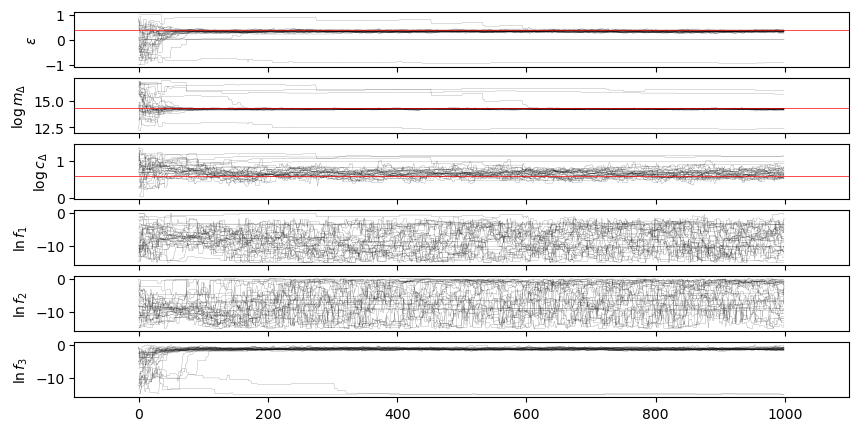

In [1183]:
fig, axs = plt.subplots(ndim,1, figsize=(10,5), sharex=True);
[[axs[i].plot(sampler.chain[j,:,i], c='k', lw=0.1) for i in range(ndim)] for j in range(nwalkers)];
[ax.set_xlim(-100, nsteps+100) for ax in axs];

axs[0].axhline(ell, lw=0.5, c='r');
axs[1].axhline(np.log10(mdelta), lw=0.5, c='r');
axs[2].axhline(np.log10(cdelta), lw=0.5, c='r');

axs[0].set_ylabel(r'$\epsilon$');
axs[1].set_ylabel(r'$\log m_{\Delta}$');
axs[2].set_ylabel(r'$\log c_{\Delta}$');
axs[3].set_ylabel(r'$\ln f_1$');
axs[4].set_ylabel(r'$\ln f_2$');
axs[5].set_ylabel(r'$\ln f_3$');

In [1184]:
labels = ['\epsilon', '\log M_\Delta', '\log c_\Delta', '\ln f_1', '\ln f_2', 'ln f_3']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q_ = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q_[0], q_[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1185]:
ps = [np.percentile(flat_samples[:,i], [16,50,84])[1] for i in range(ndim)]

In [1186]:
ds4theta, eta_func = _delta_sigma_4theta(ps[0], r_, 10**ps[1], 10**ps[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)
dsconst, eta_func = _delta_sigma_const(ps[0], r_, 10**ps[1], 10**ps[2], z_cl, cosmo, hpmd='nfw', sample_N=1000)

# sigma_nfw = _sigma(r_, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200)/0.7
_dsmono = InterpolatedUnivariateSpline(np.logspace(-3,3,2000), delta_sigma_monopole(np.logspace(-3,3,2000), ps), k=3)
dsmono = _dsmono(r_)
# eta_0 = np.gradient(np.log(sigma_nfw),r_)*r_

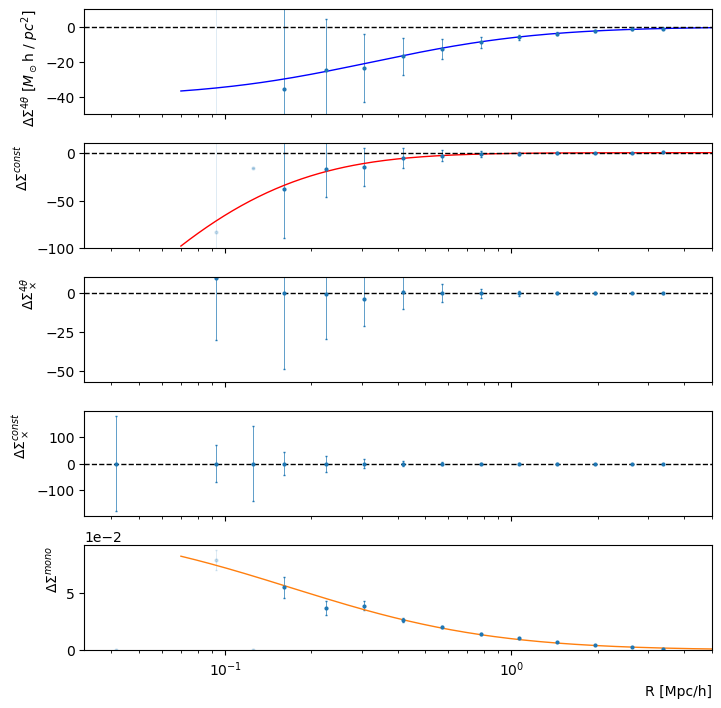

In [1187]:
fig, axs = plt.subplots(5,1, figsize=(7,7), sharex=True);
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
plt.tight_layout();

## Delta Sigma 4theta
axs[0].errorbar(r_bins[order], np.array(delta_sigmas_4theta)[:,0][order] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta)[:,1][order] / 0.7 / 1e12, fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1);
axs[0].errorbar(r_bins[~order], np.array(delta_sigmas_4theta)[:,0][~order] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta)[:,1][~order] / 0.7 / 1e12, fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1, alpha=0.2, c='C0');
axs[0].plot(r_, ds4theta/0.7 / 1e12, 'b-', lw=1);
axs[0].set_ylabel(r'$\Delta \Sigma^{4\theta}$ [$M_\odot$h / $pc^2$]', loc='top');
axs[0].set_xscale('log');
axs[0].set_ylim(-50, 10);
# axs[0].set_ylim(-10, 50);
axs[0].axhline(0, lw=1, ls='--', c='k');
# axs[0].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const
axs[1].errorbar(r_bins[order], np.array(delta_sigmas_const)[:,0][order] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const)[:,1][order] / 0.7 / 1e12, fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1);
axs[1].errorbar(r_bins[~order], np.array(delta_sigmas_const)[:,0][~order] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const)[:,1][~order] / 0.7 / 1e12, fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1, alpha=0.2, c='C0');
axs[1].plot(r_, dsconst/0.7 / 1e12, 'r-', lw=1)
axs[1].set_ylabel(r'$\Delta \Sigma^{const}$', loc='top');
axs[1].set_xscale('log');
axs[1].set_ylim(-100, 10);
# axs[1].set_ylim(-10, 100);
axs[1].axhline(0, lw=1, ls='--', c='k');
# axs[1].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma 4theta X
axs[2].errorbar(r_bins, np.array(delta_sigmas_4theta_cross)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_4theta_cross)[:,1] / 0.7 / 1e12, fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1);
axs[2].set_ylabel(r'$\Delta \Sigma^{4\theta}_\times$', loc='top');
axs[2].set_xscale('log');
axs[2].set_ylim(top=10);
# axs[2].set_ylim(-10, 100);
axs[2].axhline(0, lw=1, ls='--', c='k');
# axs[2].axvline(rs, lw=1, ls='-', c='k');

## Delta Sigma const X
axs[3].errorbar(r_bins, np.array(delta_sigmas_const_cross)[:,0] / 0.7 / 1e12, yerr=np.array(delta_sigmas_const_cross)[:,1] / 0.7 / 1e12, fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1);
axs[3].set_ylabel(r'$\Delta \Sigma^{const}_\times$', loc='top');
axs[3].set_xscale('log');
axs[3].axhline(0, lw=1, ls='--', c='k');
# axs[3].axvline(rs, lw=1, ls='-', c='k');

axs[4].errorbar(r_bins[order], abs(np.array(gammat_avg)[:,0][order]), yerr=abs(np.array(gammat_avg)[:,1][order]), fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1);
axs[4].errorbar(r_bins[~order], abs(np.array(gammat_avg)[:,0][~order]), yerr=abs(np.array(gammat_avg)[:,1][~order]), fmt='o', markersize=2, ls='none', elinewidth=0.5, capsize=1, alpha=0.2, c='C0');
# axs[4].plot(r_, dsmono/sigma_crit/(q)**(eta_0/2), lw=1);
axs[4].plot(r_, dsmono/0.7, lw=1);
axs[4].set_xlabel('R [Mpc/h]', loc='right');
axs[4].set_ylabel('$\Delta \Sigma^{mono}$', loc='top');
axs[4].set_xlim(right=5);
axs[4].set_ylim(bottom=0);

## Calculate monopole term

The corrected monopole term should look something like:
$$ \Sigma_0(r) = \Sigma_c r^\eta_0 \left(1 + \epsilon^2 \left(\frac{1}{8} \dfrac{d \ln\Sigma}{d \ln r} + \frac{1}{16}\dfrac{d^2\ln\Sigma}{d\ln r^2} + \dfrac{1}{16}\left(\dfrac{d \ln\Sigma}{d \ln r} \right)^2 \right) \right)$$
which n terms of things we've already calculated is:
$$ \Sigma_0(r) = \Sigma_c r^\eta_0 \left(1 + \epsilon^2 \left(\frac{1}{8} \eta_0 + \frac{1}{16}\dfrac{d\eta_0}{d\ln r} + \dfrac{1}{16}\eta_0^2 \right) \right)$$.
What we need to compare then is:
$$ \langle \gamma_{+} \rangle = \frac{\bar{\Sigma}_0(<r) - \Sigma_0(r)}{\Sigma_{crit}} \equiv \bar{\kappa}_0(<r) - \kappa_0(r) $$
where
$$ \bar{\kappa}_0(<r) = \frac{2}{r^2}\int^r_0 r' \kappa_0(r')dr' $$